In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from tensorflow.keras.callbacks import (
    Callback,
    EarlyStopping,
    ReduceLROnPlateau,
)
from tqdm.keras import TqdmCallback
from tensorflow.keras.layers import BatchNormalization

In [3]:
# Load the datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


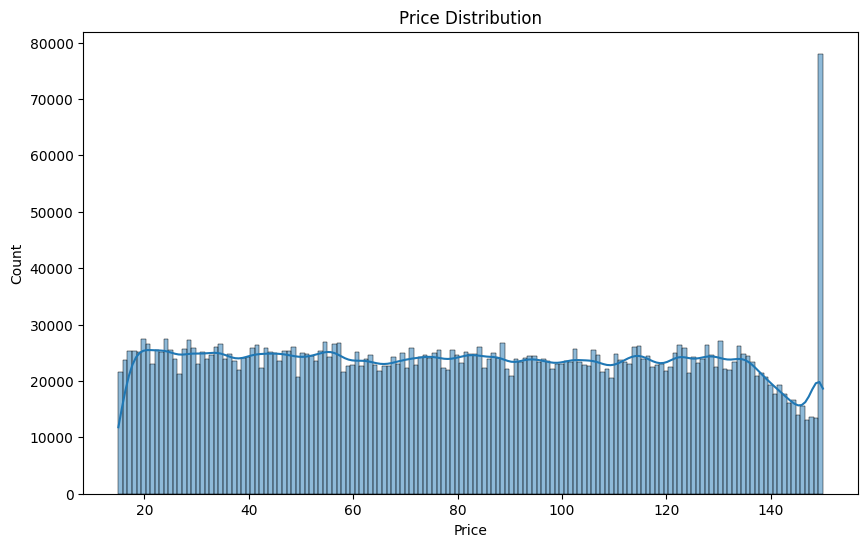

In [4]:
# Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df["Price"], kde=True)
plt.title("Price Distribution")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


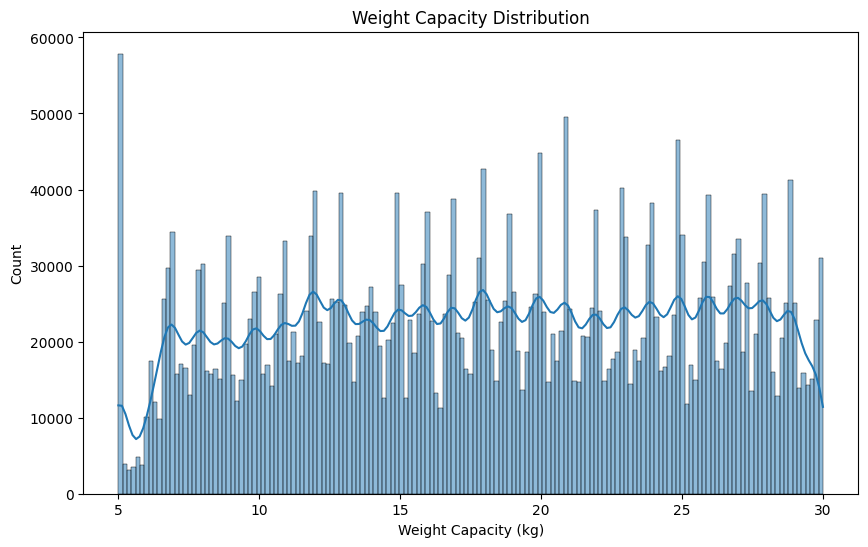

In [5]:
# Weight Capacity distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df["Weight Capacity (kg)"], kde=True)
plt.title("Weight Capacity Distribution")
plt.show()

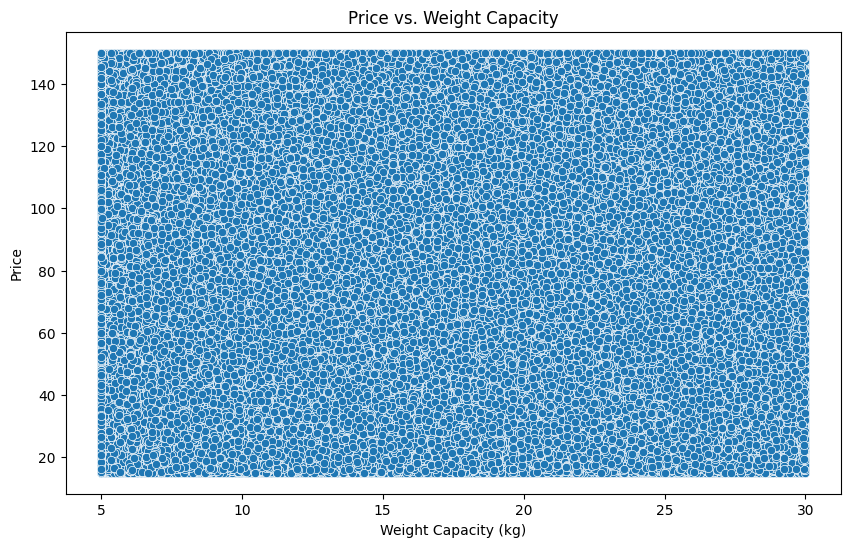

In [6]:
# Price vs. Weight Capacity
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Weight Capacity (kg)", y="Price", data=train_df)
plt.title("Price vs. Weight Capacity")
plt.show()

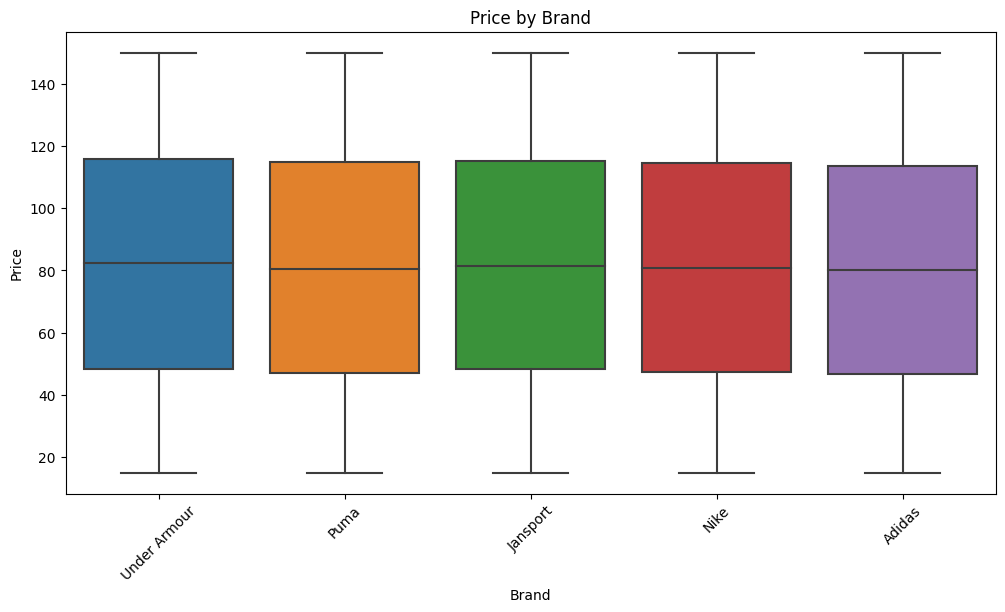

In [7]:
# Price by Brand (using boxplot for better visualization of distribution)
plt.figure(figsize=(12, 6))
sns.boxplot(x="Brand", y="Price", data=train_df)
plt.title("Price by Brand")
plt.xticks(rotation=45)
plt.show()

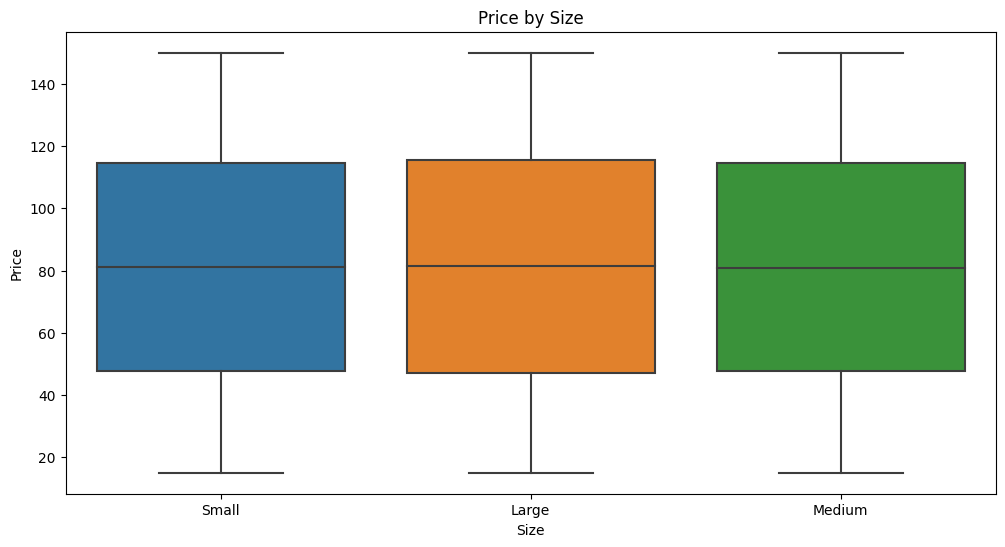

In [8]:
# Price by Size
plt.figure(figsize=(12, 6))
sns.boxplot(x="Size", y="Price", data=train_df)
plt.title("Price by Size")
plt.show()

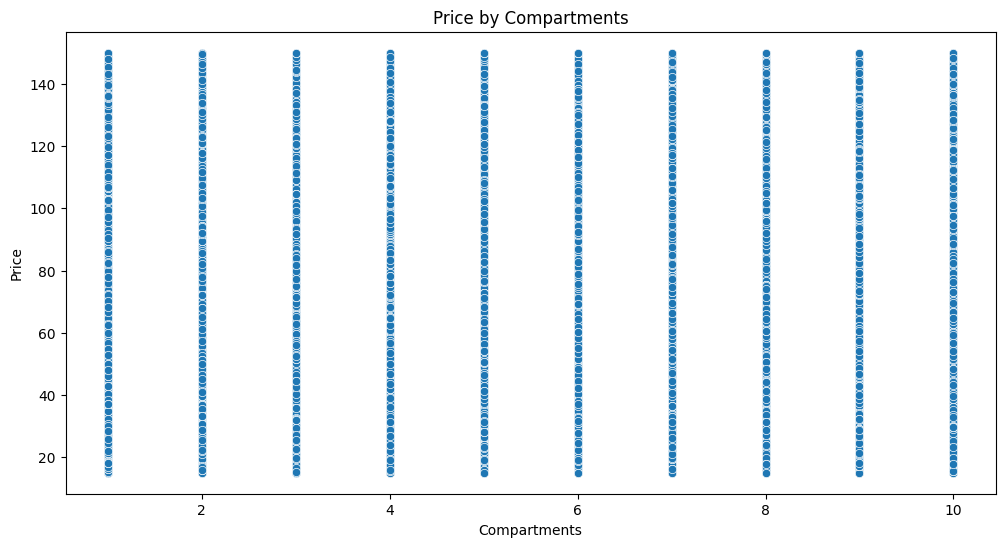

In [9]:
# Price by Compartments (using scatterplot)
plt.figure(figsize=(12,6))
sns.scatterplot(x = "Compartments", y= "Price", data=train_df)
plt.title("Price by Compartments")
plt.show()

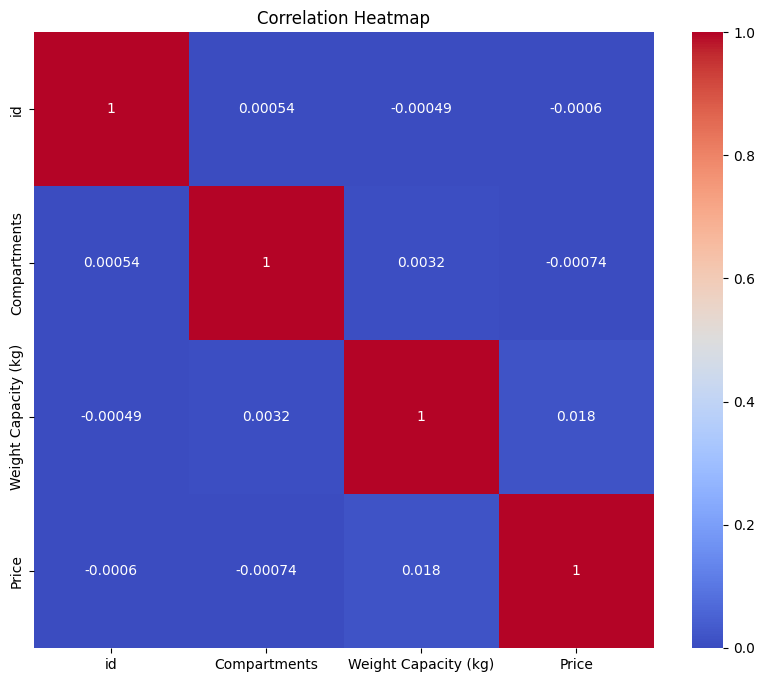

In [10]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_df = train_df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# Combine train and test for consistent preprocessing
all_data = pd.concat([train_df.drop("Price", axis=1), test_df], axis=0)

# Convert binary features to numerical (0 and 1)
for col in ["Laptop Compartment", "Waterproof"]:
    all_data[col] = all_data[col].map({"Yes": 1, "No": 0})

# Handle missing values (if any, using median for numeric and mode for categorical)
for col in all_data.columns:
    if all_data[col].isnull().any():
        if all_data[col].dtype == "object":
            all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
        else:
            all_data[col] = all_data[col].fillna(all_data[col].median())

In [12]:
# Enhanced Feature Engineering:
all_data["Brand_Material"] = all_data["Brand"] + "_" + all_data["Material"]
all_data["Size_Style"] = all_data["Size"] + "_" + all_data["Style"]
# New Features: Interactions, Polynomials
all_data["Compartments_WeightCapacity"] = (
    all_data["Compartments"] * all_data["Weight Capacity (kg)"]
)  # Interaction
all_data["WeightCapacity_Sq"] = (
    all_data["Weight Capacity (kg)"] ** 2
)  # Polynomial Feature
all_data["Compartments_Sq"] = all_data["Compartments"] ** 2

# Separate back into train and test
X = all_data[: len(train_df)].drop("id", axis=1)
y = train_df["Price"]
X_test = all_data[len(train_df) :].drop("id", axis=1)

In [13]:
# Improved Preprocessing pipeline:
categorical_features = X.select_dtypes(include="object").columns
numerical_features = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                [("scaler", StandardScaler()), ("power", PowerTransformer())]
            ),  # Add PowerTransformer
            numerical_features,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="first"),
            categorical_features,
        ),
    ],
    remainder="passthrough",  # Important: Handle any other columns
)

In [14]:
# Split the training data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# Preprocess
X_train_processed = preprocessor.fit_transform(X_train, y_train)  # Fit on X_train AND y_train
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

In [16]:
if isinstance(X_train_processed, np.ndarray):
    X_train_array = X_train_processed
else:
    X_train_array = X_train_processed.toarray()  # Convert sparse to dense

if isinstance(X_val_processed, np.ndarray):
    X_val_array = X_val_processed
else:
    X_val_array = X_val_processed.toarray()

if isinstance(X_test_processed, np.ndarray):
    X_test_array = X_test_processed
else:
    X_test_array = X_test_processed.toarray()

if np.isnan(X_train_array).any() or np.isnan(X_val_array).any() or np.isnan(X_test_array).any():
    print("NaNs detected after preprocessing.  Filling with 0.")
    X_train_processed = np.nan_to_num(X_train_array, nan=0.0)  # Use the dense arrays
    X_val_processed = np.nan_to_num(X_val_array, nan=0.0)
    X_test_processed = np.nan_to_num(X_test_array, nan=0.0)
else: #added else statement
    X_train_processed = X_train_array
    X_val_processed = X_val_array
    X_test_processed = X_test_array


In [17]:
# Build the Improved TensorFlow model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),
        tf.keras.layers.Dense(256, activation="relu"), # Increased units
        BatchNormalization(),  # Add BatchNormalization
        tf.keras.layers.Dropout(0.4), # Increased dropout
        tf.keras.layers.Dense(128, activation="relu"),
        BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation="relu"),
        BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),  # Output
    ]
)

# Compile the model (try a slightly smaller learning rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse")


In [18]:
# Callbacks (same as before, but adjusted patience)
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get("loss"))
        print(f" Epoch {epoch+1}: loss={logs.get('loss'):.4f}, val_loss={logs.get('val_loss'):.4f}")

early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)  # More patience
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10) # And patience
loss_history = LossHistory()

In [19]:
# Train
history = model.fit(
    X_train_processed,
    y_train,
    epochs=200,  # Increased epochs
    batch_size=128,  # Further increased batch size
    validation_data=(X_val_processed, y_val),
    callbacks=[TqdmCallback(verbose=0), early_stopping, reduce_lr, loss_history],
    verbose=0,
)


0epoch [00:00, ?epoch/s]

 Epoch 1: loss=1638.2833, val_loss=1515.1564
 Epoch 2: loss=1529.8914, val_loss=1517.8167
 Epoch 3: loss=1517.1821, val_loss=1529.0890
 Epoch 4: loss=1515.0885, val_loss=1514.4413
 Epoch 5: loss=1514.6124, val_loss=1516.4473
 Epoch 6: loss=1514.4088, val_loss=1514.4338
 Epoch 7: loss=1514.2529, val_loss=1514.2627
 Epoch 8: loss=1514.1613, val_loss=1514.2520
 Epoch 9: loss=1514.1013, val_loss=1515.4261
 Epoch 10: loss=1514.0040, val_loss=1514.2529
 Epoch 11: loss=1514.0139, val_loss=1514.7063
 Epoch 12: loss=1513.9430, val_loss=1514.3871
 Epoch 13: loss=1513.8669, val_loss=1514.2830
 Epoch 14: loss=1513.8528, val_loss=1514.3302
 Epoch 15: loss=1513.8400, val_loss=1514.5338
 Epoch 16: loss=1513.7441, val_loss=1515.3254
 Epoch 17: loss=1513.7593, val_loss=1514.3528
 Epoch 18: loss=1513.6917, val_loss=1514.4186
 Epoch 19: loss=1513.3130, val_loss=1514.4176
 Epoch 20: loss=1513.2432, val_loss=1514.2938
 Epoch 21: loss=1513.2639, val_loss=1514.2932
 Epoch 22: loss=1513.1940, val_loss=1514.26

In [20]:
# Evaluate
y_pred_val = model.predict(X_val_processed).flatten()
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {rmse}")

23090/23090 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step
Validation RMSE: 38.91339588973442


In [21]:
# Predict
y_pred_test = model.predict(X_test_processed).flatten()

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [22]:
# Submission
submission_df = pd.DataFrame({"id": test_df["id"], "Price": y_pred_test})
submission_df.to_csv("submission.csv", index=False)

print("Submission file 'submission.csv' created.")
print(f"Final training loss: {loss_history.losses[-1]}")

Submission file 'submission.csv' created.
Final training loss: 1513.12158203125
